Team Project Checkpoint 1
David Geis
Abhijeet Gupta
Noralene Marcum
Meadow Motz
Shruti Singh
Patrick Thomas

Note: archive.zip should be unzipped in the same folder as this notebook. 

In [4]:
import sys
!{sys.executable} -m pip install opencv-python
import cv2
import numpy as np
!pip install scikit-image
from skimage.feature import local_binary_pattern, hog
!pip install scikit-learn
from sklearn.decomposition import PCA
import joblib
import os
!pip install faiss-cpu
import faiss
!pip install tqdm
from tqdm import tqdm

# Resize image to ensure consistency
def resize_image(image, size=(300, 300)):
    return cv2.resize(image, size)

# Extract Local Binary Patterns (LBP) features
def extract_lbp_features(image, P=8, R=1, method='uniform'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# Extract Color Histogram features
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Extract SIFT features
def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        return np.mean(descriptors, axis=0)
    else:
        return np.zeros(128)

# Extract Histogram of Oriented Gradients (HOG) features
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat, _ = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return hog_feat

# Collect all image paths recursively
def collect_image_paths(image_dir):
    image_paths = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Main execution
if __name__ == '__main__':
    image_dir = 'archive/training' 

    print("Collecting image paths...")
    image_paths = collect_image_paths(image_dir)

    # Prepare data specifically for PCA
    print("Collecting data for PCA training...")
    all_images = []
    for img_path in tqdm(image_paths):
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = resize_image(img)
            gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            all_images.append(gray.flatten())

    if len(all_images) == 0:
        raise ValueError("No images found. Check your image directory path.")

    print("Training PCA...")
    pca_model = PCA(n_components=50)
    pca_model.fit(all_images)

    # Extract all features and combine
    features = []
    image_ids = []

    print("Extracting features from images...")
    for img_path in tqdm(image_paths):
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = resize_image(img)

            lbp_feat = extract_lbp_features(img_resized)
            color_hist_feat = extract_color_histogram(img_resized)
            sift_feat = extract_sift_features(img_resized)
            hog_feat = extract_hog_features(img_resized)
            pca_feat = pca_model.transform([cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY).flatten()]).flatten()

            # Combine all extracted features
            combined_features = np.concatenate((sift_feat, hog_feat, lbp_feat, color_hist_feat, pca_feat))

            features.append(combined_features)
            image_ids.append(img_path)

    features = np.array(features).astype('float32')

    print("Creating FAISS index...")
    dimension = features.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(features)
    faiss.write_index(index, 'food_images_all_features.index')

    # Save PCA model and image IDs
    joblib.dump(pca_model, 'pca_model.pkl')
    joblib.dump(image_ids, 'image_ids.pkl')

    print("Feature extraction with all methods and indexing completed successfully.")

100%|██████████| 9866/9866 [00:22<00:00, 436.49it/s]


Training PCA...
Extracting features from images...


100%|██████████| 9866/9866 [56:55<00:00,  2.89it/s]   


Creating FAISS index...
Feature extraction with all methods and indexing completed successfully.


In [5]:
import sys
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.decomposition import PCA
import joblib
import os
import faiss
from tqdm import tqdm

# Resize image to ensure consistency
def resize_image(image, size=(300, 300)):
    return cv2.resize(image, size)

# Extract Local Binary Patterns (LBP) features
def extract_lbp_features(image, P=8, R=1, method='uniform'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# Extract Color Histogram features
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Extract SIFT features
def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        return np.mean(descriptors, axis=0)
    else:
        return np.zeros(128)

# Extract Histogram of Oriented Gradients (HOG) features
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat, _ = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return hog_feat

# Collect all image paths recursively
def collect_image_paths(image_dir):
    image_paths = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Main execution
if __name__ == '__main__':
    image_dir = 'archive/training' 

    print("Collecting image paths...")
    image_paths = collect_image_paths(image_dir)

    # Prepare data specifically for PCA
    print("Collecting data for PCA training...")
    all_images = []
    for img_path in tqdm(image_paths):
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = resize_image(img)
            gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            all_images.append(gray.flatten())

    if len(all_images) == 0:
        raise ValueError("No images found. Check your image directory path.")

    print("Training PCA...")
    pca_model = PCA(n_components=50)
    pca_model.fit(all_images)

    # Extract all features and combine
    features = []
    image_ids = []

    print("Extracting features from images...")
    for img_path in tqdm(image_paths):
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = resize_image(img)

            lbp_feat = extract_lbp_features(img_resized)
            color_hist_feat = extract_color_histogram(img_resized)
            sift_feat = extract_sift_features(img_resized)
            hog_feat = extract_hog_features(img_resized)
            pca_feat = pca_model.transform([cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY).flatten()]).flatten()

            # Combine all extracted features
            combined_features = np.concatenate((sift_feat, hog_feat, lbp_feat, color_hist_feat, pca_feat))

            features.append(combined_features)
            image_ids.append(img_path)

    features = np.array(features).astype('float32')

    print("Creating FAISS index...")
    dimension = features.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(features)
    faiss.write_index(index, 'food_images_all_features.index')

    # Save PCA model and image IDs
    joblib.dump(pca_model, 'pca_model.pkl')
    joblib.dump(image_ids, 'image_ids.pkl')

    print("Feature extraction with all methods and indexing completed successfully.")

100%|██████████| 9866/9866 [00:21<00:00, 449.58it/s]


Training PCA...
Extracting features from images...


100%|██████████| 9866/9866 [36:37<00:00,  4.49it/s]  


Creating FAISS index...
Feature extraction with all methods and indexing completed successfully.


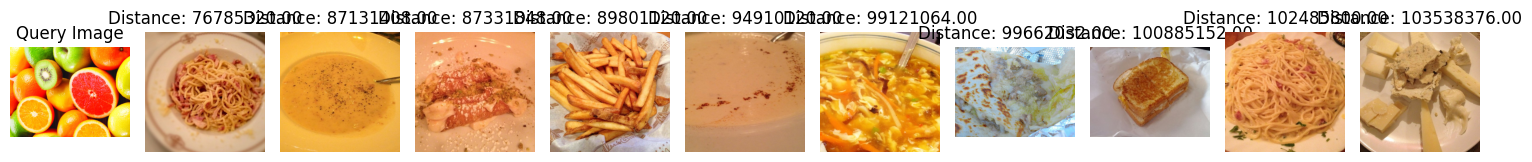

Top similar images:
Image: archive/training\Noodles-Pasta\272.jpg, Similarity Distance: 76785320.0
Image: archive/training\Soup\1034.jpg, Similarity Distance: 87131408.0
Image: archive/training\Dessert\1178.jpg, Similarity Distance: 87331848.0
Image: archive/training\Fried food\455.jpg, Similarity Distance: 89801120.0
Image: archive/training\Soup\1489.jpg, Similarity Distance: 94910120.0
Image: archive/training\Soup\1231.jpg, Similarity Distance: 99121064.0
Image: archive/training\Bread\300.jpg, Similarity Distance: 99662032.0
Image: archive/training\Bread\825.jpg, Similarity Distance: 100885152.0
Image: archive/training\Noodles-Pasta\55.jpg, Similarity Distance: 102485800.0
Image: archive/training\Dairy product\37.jpg, Similarity Distance: 103538376.0


In [7]:
import cv2
import numpy as np
import faiss
import joblib
from skimage.feature import local_binary_pattern, hog
from sklearn.decomposition import PCA
!pip install matplotlib
import matplotlib.pyplot as plt

# Resize image to ensure consistency
def resize_image(image, size=(300, 300)):
    return cv2.resize(image, size)

# Extract Local Binary Patterns (LBP) features
def extract_lbp_features(image, P=8, R=1, method='uniform'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# Extract Color Histogram features
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Extract SIFT features
def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        return np.mean(descriptors, axis=0)
    else:
        return np.zeros(128)

# Extract Histogram of Oriented Gradients (HOG) features
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat, _ = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return hog_feat

# Extract PCA features (requires a trained PCA model)
def extract_pca_features(image, pca_model):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature_vector = gray.flatten()
    reduced_features = pca_model.transform([feature_vector])
    return reduced_features.flatten()

# Resize image to ensure consistency
def resize_image(image, size=(300, 300)):
    return cv2.resize(image, size)

# Load your FAISS index, PCA model, and image IDs
faiss_index = faiss.read_index('food_images_all_features.index')
pca_model = joblib.load('pca_model.pkl')
image_ids = joblib.load('image_ids.pkl')

# Function to search similar images
def search_similar_images(query_image_path, top_k=10):
    img = cv2.imread(query_image_path)
    img_resized = resize_image(img)

    lbp_feat = extract_lbp_features(img_resized)
    color_hist_feat = extract_color_histogram(img_resized)
    sift_feat = extract_sift_features(img_resized)
    hog_feat = extract_hog_features(img_resized)
    pca_feat = extract_pca_features(img_resized, pca_model)

    combined_features = np.concatenate((sift_feat, hog_feat, lbp_feat, color_hist_feat, pca_feat)).astype('float32')

    distances, indices = faiss_index.search(np.array([combined_features]), top_k)

    similar_images = [(image_ids[idx], distances[0][i]) for i, idx in enumerate(indices[0])]

    return similar_images

# Visualization of results
def visualize_results(query_image_path, similar_images):
    plt.figure(figsize=(15, 5))

    # Display query image
    query_img = cv2.cvtColor(cv2.imread(query_image_path), cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(similar_images) + 1, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')

    # Display similar images
    for i, (img_path, distance) in enumerate(similar_images):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(similar_images) + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Distance: {distance:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run example
query_image = 'archive/validation/Vegetable-Fruit/11.jpg'
similar_images = search_similar_images(query_image)

visualize_results(query_image, similar_images)

print("Top similar images:")
for path, distance in similar_images:
    print(f"Image: {path}, Similarity Distance: {distance}")